# Step 5 - Tissue Specificity
-- Alex Warwick Vesztrocy, March 2024

This notebook contains the code to compute tissue specicity scores ($\tau$). To do this the TPM data is first transformed using the `arcsinh` function -- $\textrm{arcsinh}(x) := \ln (x + \sqrt{x^2 + 1})$ -- before taking the mean value of any replicates.

In [1]:
from collections import defaultdict
from scipy.stats import ks_2samp
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd
import seaborn as sns

EXPR = './results/expr'

TAU_RESULTS = './results/tau'
!mkdir -p {TAU_RESULTS}

In [26]:
def compute_tau(expr_df):
    def tau_(x):
        max_x = x.max()
        if max_x > 0 and len(x) > 1:
            # if gene is not expressed anywhere, we don't have enough data to include
            # if only one tissue, do not include and set to -1 as a flag.
            return np.sum(1 - (x/max_x))/(len(x)-1)
        else:
            return -1
    
    def transform_and_group(df):
        def gen():
            # group on the first aspect of multi-index for columns
            for k in set(map(lambda x: x[0], df.columns)):
                # transform and average
                yield pd.DataFrame({k: df.loc[:,k].apply(np.arcsinh).mean(axis=1)})
    
        return pd.concat(gen(), axis=1)

    tau_df = transform_and_group(expr_df).apply(tau_, axis=1)

    # remove genes where tau=-1. these genes must have >2.0 for another tissue.
    return tau_df[tau_df > -1]

In [27]:
def compute_for_db(db_fn, out_fn):
    in_db = pd.HDFStore(db_fn, mode='r')
    if not os.path.isfile(out_fn):
        for n in tqdm(in_db.root):
            sp = n._v_name
            print(sp)
            expr_df = pd.read_hdf(in_db, sp)
            compute_tau(expr_df).to_hdf(out_fn, sp, complevel=9, complib='zlib')

In [28]:
# Main categories only
compute_for_db(db_fn=f'{EXPR}/animal_maincat_tpm_expr.h5',
               out_fn=f'{TAU_RESULTS}/animal_maincat_tau.h5')
# Categorised data
compute_for_db(db_fn=f'{EXPR}/animal_categorised_tpm_expr.h5',
               out_fn=f'{TAU_RESULTS}/animal_categorised_tau.h5')
# All data
compute_for_db(db_fn=f'{EXPR}/animal_tpm_expr.h5',
               out_fn=f'{TAU_RESULTS}/animal_alldata_tau.h5')

In [29]:
# General tissue categorisation
compute_for_db(db_fn=f'{EXPR}/plant_general_tpm_expr.h5',
               out_fn=f'{TAU_RESULTS}/plant_general_tau.h5')
# Specific tissue categorisation
compute_for_db(db_fn=f'{EXPR}/plant_specific_tpm_expr.h5',
               out_fn=f'{TAU_RESULTS}/plant_specific_tau.h5')

0it [00:00, ?it/s]

AMBTC
ARATH
BRANA
CAPAN
CUCSA
HELAN
MAIZE
MANES
MARPO
MEDTR
ORYSJ
PHYPA
POPTR
SELML
SETIT
SOLLC
SOLTU
SOYBN
VITVI
WHEAT


0it [00:00, ?it/s]

AMBTC
ARATH
BRANA
CAPAN
CUCSA
HELAN
MAIZE
MANES
MARPO
MEDTR
ORYSJ
PHYPA
POPTR
SELML
SETIT
SOLLC
SOLTU
SOYBN
VITVI
WHEAT


---

## Plot distn per-species

Want to have a look and see whether the distributions are similar per-species. 

In [5]:
# species that have enough data and are in PANTHER
dataset = {'animals': {'BOVIN','CHICK','DROME','FELCA','GORGO','HORSE','HUMAN','LEPOC','MACMU','MONDO','MOUSE','ORNAN','ORYLA','PANTR','PIG','RAT'},
           'plants': {'AMBTC','ARATH','BRANA','CAPAN','CUCSA','HELAN','MAIZE','MANES','MARPO','MEDTR','ORYSJ','PHYPA','POPTR','SELML','SETIT','SOLLC','SOLTU','SOYBN','VITVI','WHEAT'}}

In [7]:
def read_distns(species, dbs):
    def gen():
        for sp in species:
            z = []
            for (db_key, db) in dbs.items():
                z.append(pd.DataFrame({'tau': pd.read_hdf(db, sp)}))
                z[-1]['type'] = db_key
            df = pd.concat(z)
            df['species'] = sp
            yield df
            
    return pd.concat(gen())

In [8]:
animal_df = read_distns(dataset['animals'],
                        {'main category only': pd.HDFStore(f'{TAU_RESULTS}/animal_maincat_tau.h5', mode='r'),
                         'categorised': pd.HDFStore(f'{TAU_RESULTS}/animal_categorised_tau.h5', mode='r')})

In [38]:
plant_df = read_distns(dataset['plants'],
                       {'general': pd.HDFStore(f'{TAU_RESULTS}/plant_general_tau.h5', mode='r'),
                        'specific': pd.HDFStore(f'{TAU_RESULTS}/plant_specific_tau.h5', mode='r')})

,tau,type,species
gene_id,,,
ENSSSCG00000000002,0.733438,main category only,PIG
ENSSSCG00000000003,0.399908,main category only,PIG
ENSSSCG00000000005,0.527448,main category only,PIG
ENSSSCG00000000006,0.625656,main category only,PIG
ENSSSCG00000000007,0.309803,main category only,PIG
...,...,...,...
ENSFCAG00000053855,1.000000,categorised,FELCA
ENSFCAG00000053857,0.951151,categorised,FELCA
ENSFCAG00000053858,0.887292,categorised,FELCA


Text(0, 0.5, 'Tissue Specificity ($\\tau$)')

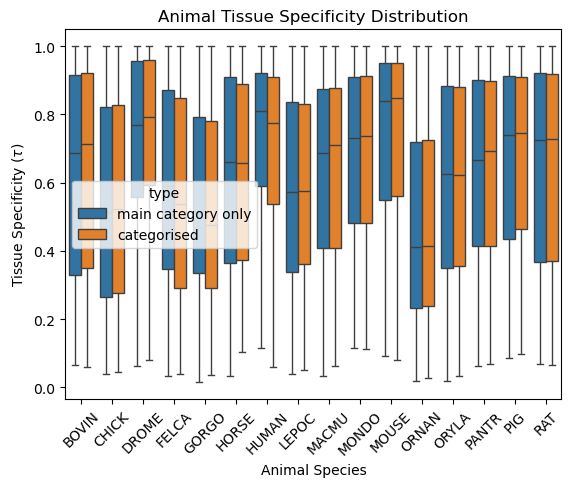

In [18]:
ax = sns.boxplot(data=animal_df.sort_values('species'), x='species', y='tau', hue='type', showfliers=False)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Animal Tissue Specificity Distribution')
ax.set_xlabel('Animal Species')
ax.set_ylabel('Tissue Specificity ($\\tau$)')

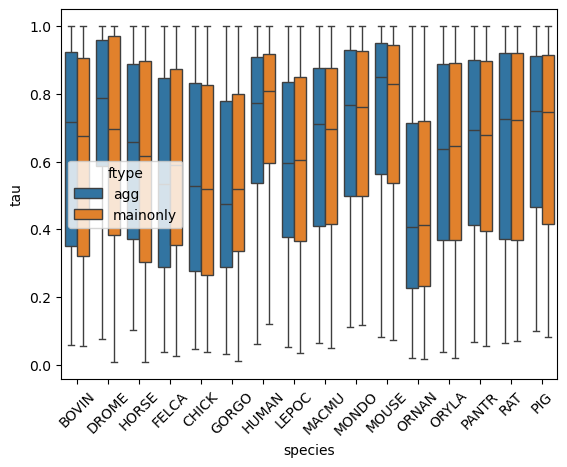

In [82]:
ax = sns.boxplot(data=plant_df.sort_values('species'), x='species', y='tau', hue='type', showfliers=False)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Plant Tissue Specificity Distribution')
ax.set_xlabel('Plant Species')
ax.set_ylabel('Tissue Specificity ($\\tau$)')